# XGBoost風 勾配ブースティングのスクラッチ実装 (NumPy) - 回帰

このノートブックでは、Tianqi Chen氏とCarlos Guestrin氏の論文「XGBoost: A Scalable Tree Boosting System」の主要なアルゴリズム的アイデアに基づき、NumPyとPython標準ライブラリのみを使用してXGBoost風の勾配ブースティング回帰器をスクラッチから実装します。

**目的:**
XGBoostの中核となるアルゴリズム、特に正則化された目的関数、損失関数の二階微分までの利用、そしてそれに基づいた木の分割評価（Gain）と葉ノードの最適重みの計算方法を理解することを目的とします。

**扱うタスク:** 回帰  
**損失関数:** 二乗誤差 $L(y, \hat{y}) = \frac{1}{2}(y - \hat{y})^2$

**主な内容:**
1. 必要なライブラリのインポート
2. データセットの準備
3. XGBoostアルゴリズムの理論的背景と主要な数式の導出
4. `XGBoostNode` クラス（決定木のノード構造）の実装
5. `XGBoostTree` クラス（XGBoostの単一決定木）の実装
6. `XGBoostRegressor` クラス（XGBoostアンサンブルモデル本体）の実装
7. モデルの学習と評価

## 1. 必要なライブラリのインポート

In [39]:
import numpy as np
import time # 学習時間の計測用

## 2. データセットの準備 (回帰用)

サンプルデータ X_sample_xgb (shape): (80, 1)
サンプルラベル y_sample_xgb (shape): (80,)


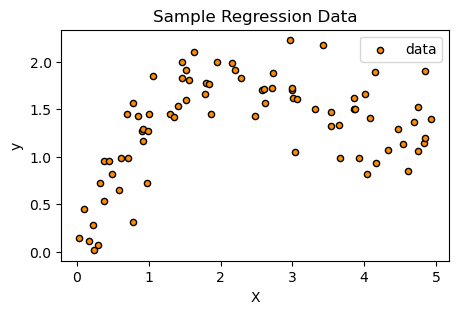

In [40]:
np.random.seed(42) 
X_sample_xgb = np.sort(5 * np.random.rand(80, 1), axis=0)
y_sample_xgb = np.sin(X_sample_xgb).ravel() + X_sample_xgb.ravel() * 0.5 + np.random.randn(80) * 0.3

feature_types_sample_xgb = ['numeric'] 

print("サンプルデータ X_sample_xgb (shape):", X_sample_xgb.shape)
print("サンプルラベル y_sample_xgb (shape):", y_sample_xgb.shape)

# 簡単なプロット
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 3))
plt.scatter(X_sample_xgb, y_sample_xgb, s=20, edgecolor="black", c="darkorange", label="data")
plt.xlabel("X")
plt.ylabel("y")
plt.title("Sample Regression Data")
plt.legend()
plt.show()

## 3. XGBoostアルゴリズムの理論的背景

XGBoostは、勾配ブースティングアルゴリズムの一つであり、高い予測性能とスケーラビリティで知られています。その核心は、正則化された目的関数と、損失関数の二階微分までを利用した効率的な最適化にあります。

### 3.1 目的関数 (Objective Function)

XGBoostでは、モデルの予測精度と複雑度のバランスを取るために、正則化された目的関数を最小化します。
$t$回目のイテレーションで追加する新しい関数（決定木）を $f_t$ とすると、このイテレーションでの目的関数 $\mathcal{L}^{(t)}$ は以下のように表されます。

$\mathcal{L}^{(t)} = \sum_{i=1}^{n} l(y_i, \hat{y}_i^{(t-1)} + f_t(x_i)) + \Omega(f_t)$

ここで、
*   $n$: サンプル数
*   $y_i$: $i$番目のサンプルの真の目的変数値
*   $\hat{y}_i^{(t-1)}$: $(t-1)$回目のイテレーションまでのモデルによる$i$番目のサンプルの予測値
*   $f_t(x_i)$: $t$番目に追加する決定木による$i$番目のサンプルの予測値（補正値）
*   $l(y_i, \hat{y}_i)$: 微分可能な損失関数。例えば、回帰タスクの二乗誤差損失は $l(y_i, \hat{y}_i) = \frac{1}{2}(y_i - \hat{y}_i)^2$
*   $\Omega(f_t)$: $t$番目の決定木の複雑度に対する正則化項。以下のように定義されます。
    $\Omega(f_t) = \gamma T + \frac{1}{2}\lambda \sum_{j=1}^{T} w_j^2$
    *   $T$: $t$番目の決定木の葉の数
    *   $w_j$: $j$番目の葉が出力するスコア（重み）
    *   $\gamma$: 葉の数 $T$ に対するペナルティ係数。これが大きいほど、葉の少ない単純な木が好まれます。
    *   $\lambda$: 葉のスコア $w_j$ のL2正則化係数。これが大きいほど、葉のスコアが0に近くなり、過学習を抑制します。

### 3.2 目的関数の近似 (二階テイラー展開)

上記の目的関数 $\mathcal{L}^{(t)}$ は、$f_t$ に対して複雑な形をしています。そこで、XGBoostではこの目的関数を $\hat{y}_i^{(t-1)}$ の周りで二階のテイラー展開を用いて近似します。
損失関数 $l(y_i, \hat{y}_i^{(t-1)} + f_t(x_i))$ を $f_t(x_i)=0$ の周りで展開すると、

$l(y_i, \hat{y}_i^{(t-1)} + f_t(x_i)) \approx l(y_i, \hat{y}_i^{(t-1)}) + g_i f_t(x_i) + \frac{1}{2} h_i f_t^2(x_i)$

ここで、
*   $g_i = \left[ \frac{\partial l(y_i, \hat{y})}{\partial \hat{y}} \right]_{\hat{y}=\hat{y}_i^{(t-1)}}$ は、損失関数の $\hat{y}_i^{(t-1)}$ における一階微分（勾配）。
*   $h_i = \left[ \frac{\partial^2 l(y_i, \hat{y})}{\partial \hat{y}^2} \right]_{\hat{y}=\hat{y}_i^{(t-1)}}$ は、損失関数の $\hat{y}_i^{(t-1)}$ における二階微分（ヘシアン）。

この近似を元の目的関数に代入し、$f_t$ に依存しない定数項 $l(y_i, \hat{y}_i^{(t-1)})$ を無視すると、最適化すべき目的関数 $\tilde{\mathcal{L}}^{(t)}$ は以下のように簡略化されます。

$\tilde{\mathcal{L}}^{(t)} = \sum_{i=1}^{n} [g_i f_t(x_i) + \frac{1}{2} h_i f_t^2(x_i)] + \Omega(f_t)$
$\tilde{\mathcal{L}}^{(t)} = \sum_{i=1}^{n} [g_i f_t(x_i) + \frac{1}{2} h_i f_t^2(x_i)] + \gamma T + \frac{1}{2}\lambda \sum_{j=1}^{T} w_j^2$

### 3.3 木の構造と葉の重み

決定木 $f_t$ は、入力 $x_i$ をいずれかの葉 $j$ にマッピングし、その葉の重み $w_j$ を出力します。
つまり、$f_t(x_i) = w_{q(x_i)}$ と書けます。ここで、$q(x_i)$ はインスタンス $x_i$ が属する葉のインデックスを表す関数です。
$I_j = \{i | q(x_i) = j\}$ を葉 $j$ に属するインスタンスのインデックス集合とすると、目的関数は以下のように書き換えられます。

$\tilde{\mathcal{L}}^{(t)} = \sum_{j=1}^{T} \left[ \left(\sum_{i \in I_j} g_i\right) w_j + \frac{1}{2} \left(\sum_{i \in I_j} h_i + \lambda\right) w_j^2 \right] + \gamma T$

$G_j = \sum_{i \in I_j} g_i$ （葉 $j$ に属するサンプルの一階微分の合計）
$H_j = \sum_{i \in I_j} h_i$ （葉 $j$ に属するサンプルの二階微分の合計）
と置くと、

$\tilde{\mathcal{L}}^{(t)} = \sum_{j=1}^{T} \left[ G_j w_j + \frac{1}{2} (H_j + \lambda) w_j^2 \right] + \gamma T$

木の構造 $q(x)$（つまり、$T$ と各 $I_j$）が固定されている場合、各葉の最適な重み $w_j^*$ は、上記の式を $w_j$ で微分して0と置くことで求められます。
$\frac{\partial \tilde{\mathcal{L}}^{(t)}}{\partial w_j} = G_j + (H_j + \lambda) w_j = 0$
よって、最適な葉の重みは、

$w_j^* = - \frac{G_j}{H_j + \lambda}$

この最適な重みを目的関数に代入すると、その木の構造 $q(x)$ に対する目的関数の最小値（スコア、論文ではobj\*と表記される値の符号反転に近い）が得られます。

$\text{obj}^* = - \frac{1}{2} \sum_{j=1}^{T} \frac{G_j^2}{H_j + \lambda} + \gamma T$

この $\text{obj}^*$ の値が小さいほど、その木の構造は良いと評価されます。（実際には、この式の符号を反転させたものを最大化します。）

### 3.4 分割評価指標 (Split Finding Criterion - Gain)

決定木を構築する際、どの特徴量のどの値で分割するかを決定する必要があります。XGBoostでは、分割によって上記の目的関数値がどれだけ改善するか（小さくなるか）を評価します。これをGain（利得）と呼びます。
あるノードを左の子ノード $L$ と右の子ノード $R$ に分割する場合のGainは以下のように定義されます。

$\text{Gain} = \text{obj}_{\text{parent}}^* - (\text{obj}_{\text{left}}^* + \text{obj}_{\text{right}}^*)$

ここで、$\text{obj}_{\text{parent}}^*$ は分割前のノードのスコア、$\text{obj}_{\text{left}}^*$ と $\text{obj}_{\text{right}}^*$ はそれぞれ分割後の左と右の子ノードのスコアです。
具体的に書くと、
$\text{obj}_{\text{parent}}^* = - \frac{1}{2} \frac{(G_L+G_R)^2}{(H_L+H_R) + \lambda} + \gamma \cdot 1$ (分割前は葉が1つと仮定)
$\text{obj}_{\text{left}}^* + \text{obj}_{\text{right}}^* = - \frac{1}{2} \frac{G_L^2}{H_L + \lambda} - \frac{1}{2} \frac{G_R^2}{H_R + \lambda} + \gamma \cdot 2$ (分割後は葉が2つ)

よって、Gainは、
$\text{Gain} = \left( - \frac{1}{2} \frac{(G_L+G_R)^2}{H_L+H_R + \lambda} + \gamma \right) - \left( - \frac{1}{2} \frac{G_L^2}{H_L + \lambda} - \frac{1}{2} \frac{G_R^2}{H_R + \lambda} + 2\gamma \right)$
$\text{Gain} = \frac{1}{2} \left[ \frac{G_L^2}{H_L + \lambda} + \frac{G_R^2}{H_R + \lambda} - \frac{(G_L+G_R)^2}{H_L+H_R + \lambda} \right] - \gamma$

アルゴリズムは、このGainが最大となるような特徴量と分割点を選んで木を成長させます。Gainが0以下になる場合は、それ以上分割を行いません。

### 3.5 損失関数が二乗誤差の場合の $g_i$ と $h_i$

本ノートブックで扱う二乗誤差損失 $L(y_i, \hat{y}_i) = \frac{1}{2}(y_i - \hat{y}_i)^2$ の場合、
*   一階微分: $g_i = \frac{\partial L}{\partial \hat{y}_i} = \hat{y}_i - y_i$
*   二階微分: $h_i = \frac{\partial^2 L}{\partial \hat{y}_i^2} = 1$

これらを上記の式に代入して計算を進めます。

### 3.6 XGBoostの学習アルゴリズムの流れ

1.  **初期化**: 全体の予測値 $\hat{y}_i^{(0)}$ を決定します（例: 0または目的変数の平均値）。
2.  **各木の構築 (イテレーション $t=1 \dots M$)**:  
    a.  現在の予測値 $\hat{y}_i^{(t-1)}$ を用いて、各サンプル $i$ の一階微分 $g_i$ と二階微分 $h_i$ を計算します。  
    b.  新しい決定木 $f_t(x)$ を構築します。  
        b-i.  ルートノードから開始し、再帰的にノードを分割します。  
        b-ii. 各ノードで、可能な全ての特徴量と分割点について上記の **Gain** を計算します。  
        b-iii.最もGainが大きい分割を選択します。もし最大のGainが0以下（または閾値以下）であれば、そのノードを葉ノードとします。  
        b-iv. 葉ノードに到達したら、その葉ノードの最適重み $w_j^* = - G_j / (H_j + \lambda)$ を計算し、葉の出力値とします。  
    c.  モデル全体の予測を更新します: $\hat{y}_i^{(t)} = \hat{y}_i^{(t-1)} + \nu \cdot f_t(x_i)$。ここで $\nu$ は学習率です。$f_t(x_i)$ は、$x_i$ が属する葉の重み $w_j^*$ です。  
3.  **最終予測**: $\hat{y}_i = \hat{y}_i^{(M)}$  

## 4. XGBoostRegressorクラスの実装

### 4.1 `XGBoostNode` クラス (決定木のノード構造)

このクラスは、XGBoostの決定木における各ノード（中間ノードまたは葉ノード）の情報を保持します。

In [41]:
class XGBoostNode:
    def __init__(
            self,
            feature_index=None,
            threshold=None,
            category=None,
            feature_type=None,
            value=None,
            left_child=None,
            right_child=None,
            is_leaf=False,
            # デバッグや可視化用
            sum_g=None,
            sum_h=None,
            num_samples=None,
            depth=None,
            gain=None,
    ):
        self.feature_index = feature_index  # 分割に使用する特徴量のインデックス
        self.threshold = threshold          # 分割の閾値
        self.category = category            # カテゴリ変数の値（もしあれば）
        self.feature_type = feature_type    # 特徴量の型（numeric, categorical）
        self.value = value                  # 葉ノードの場合の最適重み（w_j^*）
        self.left_child = left_child        # 左の子ノード
        self.right_child = right_child      # 右の子ノード
        self.is_leaf = is_leaf              # 葉ノードかどうか

        # デバッグや可視化用の情報
        self.sum_g = sum_g                  # このノードに属するサンプルのg_iの合計
        self.sum_h = sum_h                  # このノードに属するサンプルのh_iの合計
        self.num_samples = num_samples      # このノードに属するサンプル数
        self.depth = depth                  # ノードの深さ
        self.gain = gain                    # このノードでの分割によって得られたGain（中間ノードの場合）

    def __str__(self): # デバッグ表示用
        if self.is_leaf:
            return (f"Leaf(value={self.value:.4f}, samples={self.num_samples}, "
                    f"sum_g={self.sum_g:.2f}, sum_h={self.sum_h:.2f}, depth={self.depth})")
        else:
            if self.feature_type == 'numeric':
                condition = f"Feat_{self.feature_index} <= {self.threshold:.2f}"
            else:
                condition = f"Feat_{self.feature_index} == {self.category}"
            return (f"Node({condition}, samples={self.num_samples}, gain={self.gain:.4f}, "
                    f"sum_g={self.sum_g:.2f}, sum_h={self.sum_h:.2f}, depth={self.depth})")

### 4.2 `XGBoostTree` クラス (単一のXGBoost決定木)

このクラスは、XGBoostの分割基準と葉の重み計算ロジックを用いて単一の決定木を構築・保持します。
`fit` メソッドは、一階微分 `g` と二階微分 `h` を受け取って木を学習します。
`predict` メソッドは、入力データに対して葉の重みを返します。

In [42]:
class XGBoostTree:
    def __init__(
            self,
            max_depth=3,
            min_samples_split=2,
            min_samples_leaf=1,
            reg_lambda=1.0,
            gamma=0.0,
            max_features=None,
    ):
        self.root = None                            # 木のルートノード
        self.max_depth = max_depth                  # 木の最大深さ
        self.min_samples_split = min_samples_split  # ノードを分割するための最小サンプル数
        self.min_samples_leaf = min_samples_leaf    # 葉ノードに残すための最小サンプル数
        self.reg_lambda = reg_lambda                # 正則化パラメータ λ
        self.gamma = gamma                          # 木の複雑度ペナルティ
        self.max_features = max_features            # 分割に使用する特徴量の最大数（Noneの場合は全ての特徴量を使用）
        self.feature_types = None                   # fit時に設定される特徴量の型

    def _calculate_leaf_weight(self, G_node, H_node):
        """
        葉ノードの重みを計算する関数
        parameters:
            G_node: ノードに属するサンプルのg_iの合計
            H_node: ノードに属するサンプルのh_iの合計
        """
        # w_j^* = - G_j / (H_j + λ)
        return -G_node / (H_node + self.reg_lambda)
    
    def _calculate_split_gain(self, G_parent, H_parent, G_left, H_left, G_right, H_right):
        """
        分割によるGainを計算する関数
        parameters:
            G_parent: 親ノードに属するサンプルのg_iの合計
            H_parent: 親ノードに属するサンプルのh_iの合計
            G_left: 左の子ノードに属するサンプルのg_iの合計
            H_left: 左の子ノードに属するサンプルのh_iの合計
            G_right: 右の子ノードに属するサンプルのg_iの合計
            H_right: 右の子ノードに属するサンプルのh_iの合計
        """
        # Gain = 0.5 * [G_L^2/(H_L+λ) + G_R^2/(H_R+λ) - (G_L+G_R)^2/(H_L+H_R+λ)] - γ
        term_left = G_left**2 / (H_left + self.reg_lambda)
        term_right = G_right**2 / (H_right + self.reg_lambda)
        term_parent = (G_parent**2) / (H_parent + self.reg_lambda)
        gain = 0.5 * (term_left + term_right - term_parent) - self.gamma

        return gain
    
    def _find_best_split(self, X_node, g_node, h_node):
        '''
        最適な分割を見つける関数
        parameters:
            X_node: ノードに属するサンプルの特徴量
            g_node: ノードに属するサンプルのg_iの合計
            h_node: ノードに属するサンプルのh_iの合計
        '''
        best_split = {'gain': -np.inf} # gainを最大化するので負の無限大で初期化
        n_samples_node, n_total_features = X_node.shape

        # 現在のノードのGとH
        G_parent_node = np.sum(g_node)
        H_parent_node = np.sum(h_node)

        # min_samples_splitは分割のための最小サンプル数
        if n_samples_node < self.min_samples_split:
            return None
        
        # 特徴量のランダムサブセットを選択（max_featuresの処理）
        if self.max_features is not None:
            num_features_to_consider = n_total_features
        elif isinstance(self.max_features, int):
            num_features_to_consider = min(self.max_features, n_total_features)
        elif isinstance(self.max_features, float):
            num_features_to_consider = int(self.max_features * n_total_features)
            num_features_to_consider = max(1, num_features_to_consider)
        elif self.max_features == 'sqrt':
            num_features_to_consider = int(np.sqrt(n_total_features))
            num_features_to_consider = max(1, num_features_to_consider)
        elif self.max_features == 'log2':
            num_features_to_consider = int(np.log2(n_total_features))
            num_features_to_consider = max(1, num_features_to_consider)
        else:
            num_features_to_consider = n_total_features
        
        if num_features_to_consider < n_total_features:
            feature_indices_to_consider = np.random.choice(n_total_features, num_features_to_consider, replace=False)
        else:
            feature_indices_to_consider = np.arange(n_total_features)
        
        for feature_idx in feature_indices_to_consider:
            feature_values_at_node = X_node[:, feature_idx] # 現在のノードの当該特徴量の値
            unique_sorted_values = np.unique(feature_values_at_node)

            if self.feature_types[feature_idx] == 'numeric':
                if len(unique_sorted_values) > 1:
                    split_candidates = (unique_sorted_values[:-1] + unique_sorted_values[1:]) / 2
                else:
                    split_candidates = []

                for threshold_candidate in split_candidates:
                    # この閾値で分割した場合の左右の子ノードのインデックス
                    left_child_indices_bool = feature_values_at_node <= threshold_candidate
                    right_child_indices_bool = feature_values_at_node > threshold_candidate

                    # 葉の最小サンプル数を満たすかチェック
                    if np.sum(left_child_indices_bool) < self.min_samples_leaf or np.sum(right_child_indices_bool) < self.min_samples_leaf:
                        continue

                    # 左右の子ノードのgとhを計算
                    G_left_child = np.sum(g_node[left_child_indices_bool])
                    H_left_child = np.sum(h_node[left_child_indices_bool])
                    G_right_child = np.sum(g_node[right_child_indices_bool])
                    H_right_child = np.sum(h_node[right_child_indices_bool])

                    current_split_gain = self._calculate_split_gain(
                        G_parent_node, H_parent_node,
                        G_left_child, H_left_child,
                        G_right_child, H_right_child
                    )

                    if current_split_gain > best_split['gain']:
                        best_split = {
                            'gain': current_split_gain,
                            'feature_index': feature_idx,
                            'threshold': threshold_candidate,
                            'type': 'numeric',
                            'left_indices_bool': left_child_indices_bool,
                            'right_indices_bool': right_child_indices_bool,
                        }
            
            elif self.feature_types[feature_idx] == 'categorical':
                # XGBoostの標準ライブラリはカテゴリ特徴量をより効率的に扱うが、
                # ここでは単純に全てのカテゴリ値で分割を試みる

                for category_split_value in unique_sorted_values:
                    left_child_indices_bool = feature_values_at_node == category_split_value
                    right_child_indices_bool = feature_values_at_node != category_split_value

                    if np.sum(left_child_indices_bool) < self.min_samples_leaf or np.sum(right_child_indices_bool) < self.min_samples_leaf:
                        continue

                    G_left_child = np.sum(g_node[left_child_indices_bool])
                    H_left_child = np.sum(h_node[left_child_indices_bool])
                    G_right_child = np.sum(g_node[right_child_indices_bool])
                    H_right_child = np.sum(h_node[right_child_indices_bool])

                    current_split_gain = self._calculate_split_gain(
                        G_parent_node, H_parent_node,
                        G_left_child, H_left_child,
                        G_right_child, H_right_child
                    )

                    if current_split_gain > best_split['gain']:
                        best_split = {
                            'gain': current_split_gain,
                            'feature_index': feature_idx,
                            'category': category_split_value,
                            'type': 'categorical',
                            'left_indices_bool': left_child_indices_bool,
                            'right_indices_bool': right_child_indices_bool,
                        }
            
        if best_split['gain'] <= 0:
            return None
        return best_split
    
    def _build_tree_recursive(self, X_node, g_node, h_node, current_depth):
        '''
        再帰的に木を構築する
        parameters:
            X_node: ノードに属するサンプルの特徴量
            g_node: ノードに属するサンプルのg_iの合計
            h_node: ノードに属するサンプルのh_iの合計
            current_depth: 現在のノードの深さ 
        '''
        n_samples_node = X_node.shape[0]
        sum_g_at_node = np.sum(g_node)
        sum_h_at_node = np.sum(h_node)

        # 停止条件1: 最大深さに達した場合
        if current_depth >= self.max_depth:
            leaf_weight = self._calculate_leaf_weight(sum_g_at_node, sum_h_at_node)
            return XGBoostNode(
                value=leaf_weight,
                is_leaf=True,
                sum_g=sum_g_at_node,
                sum_h=sum_h_at_node,
                num_samples=n_samples_node,
                depth=current_depth
            )
    
        # 最適な分割を見つける
        best_split = self._find_best_split(X_node, g_node, h_node)

        # 停止条件2: 分割が見つからない場合
        if best_split is None:
            leaf_weight = self._calculate_leaf_weight(sum_g_at_node, sum_h_at_node)
            return XGBoostNode(
                value=leaf_weight,
                is_leaf=True,
                sum_g=sum_g_at_node,
                sum_h=sum_h_at_node,
                num_samples=n_samples_node,
                depth=current_depth
            )
        
        # 分割を実行して子ノードを再帰的に構築
        left_indices_bool = best_split['left_indices_bool']
        right_indices_bool = best_split['right_indices_bool']

        lef_child_node = self._build_tree_recursive(
            X_node[left_indices_bool],
            g_node[left_indices_bool],
            h_node[left_indices_bool],
            current_depth + 1
        )
        right_child_node = self._build_tree_recursive(
            X_node[right_indices_bool],
            g_node[right_indices_bool],
            h_node[right_indices_bool],
            current_depth + 1
        )

        # 現在のノードを作成
        node_params = {
            'feature_index': best_split['feature_index'],
            'feature_type': best_split['type'],
            'left_child': lef_child_node,
            'right_child': right_child_node,
            'is_leaf': False,
            'sum_g': sum_g_at_node,
            'sum_h': sum_h_at_node,
            'num_samples': n_samples_node,
            'depth': current_depth,
            'gain': best_split['gain'],
        }
        if best_split['type'] == 'numeric':
            node_params['threshold'] = best_split['threshold']
        else:
            node_params['category'] = best_split['category']

        return XGBoostNode(**node_params)
    
    def fit(self, X_train, g_train, h_train, feature_type_list):
        '''
        与えられた一階微分g_iと二階微分h_iを用いて木を学習する
        parameters:
            X_train: 学習データの特徴量
            g_train: 学習データの一階微分
            h_train: 学習データの二階微分
            feature_type_list: 特徴量の型リスト（'numeric' or 'categorical'）
        '''
        self.feature_types = feature_type_list
        self.root = self._build_tree_recursive(X_train, g_train, h_train, current_depth=0)

    def predict(self, X_test):
        '''
        学習済みの木を用いて予測を行い葉ノードの重みを返す
        '''
        if self.root is None:
            raise ValueError("The model has not been trained yet. Please call fit() first.")
        
        predictions = np.zeros(X_test.shape[0])

        for i in range(X_test.shape[0]):
            current_node = self.root
            while not current_node.is_leaf:
                sample_feature_value = X_test[i, current_node.feature_index]
                if current_node.feature_type == 'numeric':
                    if sample_feature_value <= current_node.threshold:
                        current_node = current_node.left_child
                    else:
                        current_node = current_node.right_child
                else:
                    if sample_feature_value == current_node.category:
                        current_node = current_node.left_child
                    else:
                        current_node = current_node.right_child
            predictions[i] = current_node.value
        return predictions

### 4.3 `XGBoostRegressor` クラス (本体)

このクラスが、複数の `XGBoostTree` を逐次的に学習させ、アンサンブルモデルを構築します。

In [43]:
class XGBoostRegressor:
    def __init__(self,
                 n_estimators=100,
                 learning_rate=0.1,
                 max_depth=3,
                 min_samples_split=2,
                 min_samples_leaf=1,
                 reg_lambda=1.0,
                 gamma=0.0,
                 max_features=None,
                 random_state=None,
                 #初期予測値
                 base_score=0.0
        ):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.reg_lambda = reg_lambda        # L2正則化
        self.gamma = gamma              # 木の複雑度ペナルティ
        self.max_features = max_features    # 分割に使用する特徴量の最大数
        self.random_state = random_state
        
        self.base_score = base_score  # 初期予測値 F₀(x)
        self.trees_ = []
        self.feature_types = None

    def calculate_gradients_mse(self, y_true, y_pred):
        '''
        二乗誤差損失 L = 0.5 * (y_true - y_pred) ** 2 の場合
        '''
        # g_i = dL/dy_pred = y_pred - y_true
        g = y_pred - y_true
        # h_i = d^2L/dy_pred^2 = 1
        h = np.ones_like(y_true)
        return g, h
    
    def fit(self, X_train, y_train, feature_types_ls):
        if self.random_state is not None:
            np.random.seed(self.random_state)

        self.trees_ = []
        self.feature_types = feature_types_ls
        n_samples, n_features = X_train.shape

        # 1. 初期モデル F₀(x) の決定
        current_predictions = np.full(shape=n_samples, fill_value=self.base_score)
        
        for i in range(self.n_estimators):
            # 一階微分 g と 二階微分 h を計算
            g, h = self.calculate_gradients_mse(y_train, current_predictions)

            # gとhを用いて新しい木を学習
            tree = XGBoostTree(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                reg_lambda=self.reg_lambda,
                gamma=self.gamma,
                max_features=self.max_features
            )
            tree.fit(X_train, g, h, self.feature_types)
            self.trees_.append(tree)

            # モデルの更新
            tree_predictions_for_update = tree.predict(X_train)
            current_predictions += self.learning_rate * tree_predictions_for_update

            # 学習の進捗を表示
            progress_interval = self.n_estimators // 10 if self.n_estimators >= 10 else 1
            if (i + 1) % progress_interval == 0 or i == self.n_estimators - 1:
                mse = np.mean((y_train - current_predictions) ** 2)
                print(f"Iteration {i + 1}/{self.n_estimators}, MSE: {mse:.4f}")
        print("Training completed.")

    def predict(self, X_test):
        if not self.trees_:
            if X_test.shape[0] > 0:
                return np.full(shape=X_test.shape[0], fill_value=self.base_score)
            else:
                np.array([])

        # 初期予測値 F₀(x) を設定
        current_predictions = np.full(shape=X_test.shape[0], fill_value=self.base_score)

        # 各木の葉の重みを学習率をかけて加算
        for tree in self.trees_:
            current_predictions += self.learning_rate * tree.predict(X_test)

        return current_predictions

## 5. モデルの学習と評価 (XGBoost回帰)

### 5.1 サンプルデータでのテスト (XGBoost回帰)

Iteration 10/100, MSE: 0.3333
Iteration 20/100, MSE: 0.1008
Iteration 30/100, MSE: 0.0679
Iteration 40/100, MSE: 0.0611
Iteration 50/100, MSE: 0.0591
Iteration 60/100, MSE: 0.0577
Iteration 70/100, MSE: 0.0559
Iteration 80/100, MSE: 0.0544
Iteration 90/100, MSE: 0.0529
Iteration 100/100, MSE: 0.0518
Training completed.

Sample Data (Advanced XGBoost Regression) - MSE: 0.0518


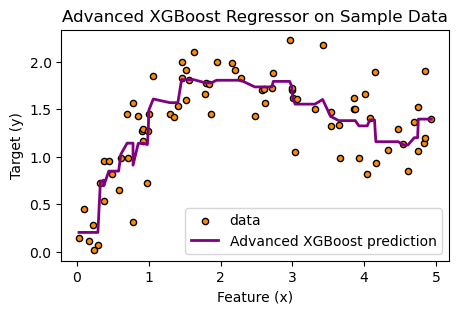

In [44]:
xgb_reg_sample = XGBoostRegressor(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=2,          # 浅い木
    min_samples_leaf=5,   # 過学習抑制
    reg_lambda=1.0,       # L2正則化
    gamma=0.0,            # 分割時の複雑度ペナルティ (0なら影響小)
    random_state=42
)

# 学習
xgb_reg_sample.fit(X_sample_xgb, y_sample_xgb, feature_types_sample_xgb)

# 予測
y_pred_sample_xgb = xgb_reg_sample.predict(X_sample_xgb)

# 簡単な評価 (MSE)
mse_sample_xgb = np.mean((y_sample_xgb - y_pred_sample_xgb)**2)
print(f"\nSample Data (Advanced XGBoost Regression) - MSE: {mse_sample_xgb:.4f}")

# プロットで確認
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 3))
plt.scatter(X_sample_xgb, y_sample_xgb, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_sample_xgb, y_pred_sample_xgb, color="purple", label="Advanced XGBoost prediction", linewidth=2)
plt.xlabel("Feature (x)")
plt.ylabel("Target (y)")
plt.title("Advanced XGBoost Regressor on Sample Data")
plt.legend()
plt.show()

### 5.2 California Housingデータセットでのテスト (XGBoost回帰)

In [45]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

housing_xgb_adv = fetch_california_housing()
X_housing_xgb_adv = housing_xgb_adv.data
y_housing_xgb_adv = housing_xgb_adv.target
housing_feature_names_xgb_adv = housing_xgb_adv.feature_names # 表示用
feature_types_housing_xgb_adv = ['numeric'] * X_housing_xgb_adv.shape[1] # 全て数値型

print("California Housing dataset loaded for Advanced XGBoost test.")

# 特徴量の標準化
scaler_xgb_adv = StandardScaler()
X_housing_scaled_xgb_adv = scaler_xgb_adv.fit_transform(X_housing_xgb_adv)

# 訓練データとテストデータに分割
X_train_h_xgb_adv, X_test_h_xgb_adv, y_train_h_xgb_adv, y_test_h_xgb_adv = train_test_split(
    X_housing_scaled_xgb_adv, y_housing_xgb_adv, test_size=0.2, random_state=42
)

print("Housing Training data shape (Advanced XGB):", X_train_h_xgb_adv.shape)
print("Housing Test data shape (Advanced XGB):", X_test_h_xgb_adv.shape)

California Housing dataset loaded for Advanced XGBoost test.
Housing Training data shape (Advanced XGB): (16512, 8)
Housing Test data shape (Advanced XGB): (4128, 8)


In [47]:
xgb_reg_housing_adv = XGBoostRegressor(
    n_estimators=100,     # 木の数を増やすと性能向上するが時間もかかる
    learning_rate=0.1,
    max_depth=5,          # XGBoostでは比較的高めの深さも使われる
    min_samples_leaf=10,  # 葉の最小サンプル数
    reg_lambda=1.0,       # L2正則化
    gamma=0.1,            # 分割の複雑度ペナルティ
    max_features=0.8,     # 各木で特徴量の80%をランダムに選択
    random_state=42
)

print("\nStarting Housing Advanced XGBoost training...")
start_time_xgb_adv = time.time()

# 学習
xgb_reg_housing_adv.fit(X_train_h_xgb_adv, y_train_h_xgb_adv, feature_types_housing_xgb_adv)

end_time_xgb_adv = time.time()
training_time_h_xgb_adv = end_time_xgb_adv - start_time_xgb_adv
print(f"Housing Advanced XGBoost training finished in {training_time_h_xgb_adv:.2f} seconds.")

# テストデータで予測
print("\nPredicting on Housing test data (Advanced XGBoost)...")
y_pred_test_h_xgb_adv = xgb_reg_housing_adv.predict(X_test_h_xgb_adv)

# 評価
mse_housing_test_xgb_adv = mean_squared_error(y_test_h_xgb_adv, y_pred_test_h_xgb_adv)
r2_housing_test_xgb_adv = r2_score(y_test_h_xgb_adv, y_pred_test_h_xgb_adv)
print(f"\nHousing Test Data - Advanced XGBoost MSE: {mse_housing_test_xgb_adv:.4f}")
print(f"Housing Test Data - Advanced XGBoost R²: {r2_housing_test_xgb_adv:.4f}")

# 学習データでの性能（過学習の度合いを見るため）
y_pred_train_h_xgb_adv = xgb_reg_housing_adv.predict(X_train_h_xgb_adv)
mse_housing_train_xgb_adv = mean_squared_error(y_train_h_xgb_adv, y_pred_train_h_xgb_adv)
r2_housing_train_xgb_adv = r2_score(y_train_h_xgb_adv, y_pred_train_h_xgb_adv)
print(f"\nHousing Training Data - Advanced XGBoost MSE: {mse_housing_train_xgb_adv:.4f}")
print(f"Housing Training Data - Advanced XGBoost R²: {r2_housing_train_xgb_adv:.4f}")


Starting Housing Advanced XGBoost training...
Iteration 1/10, MSE: 4.6553
Iteration 2/10, MSE: 3.8609
Iteration 3/10, MSE: 3.2175
Iteration 4/10, MSE: 2.6918
Iteration 5/10, MSE: 2.2640
Iteration 6/10, MSE: 1.9139
Iteration 7/10, MSE: 1.6279
Iteration 8/10, MSE: 1.3944
Iteration 9/10, MSE: 1.2029
Iteration 10/10, MSE: 1.0471
Training completed.
Housing Advanced XGBoost training finished in 480.79 seconds.

Predicting on Housing test data (Advanced XGBoost)...

Housing Test Data - Advanced XGBoost MSE: 1.0576
Housing Test Data - Advanced XGBoost R²: 0.1929

Housing Training Data - Advanced XGBoost MSE: 1.0471
Housing Training Data - Advanced XGBoost R²: 0.2167


## 6. 考察

*   **実装したアルゴリズム (XGBoost風回帰 - 二乗誤差損失)**:
    *   損失関数として二乗誤差を仮定し、その一階微分 $g_i$ と二階微分 $h_i$ を計算しました。
    *   各イテレーションで、`XGBoostTree` クラスを用いて弱学習器を学習させました。このクラスは、
        *   分割評価にXGBoost論文で定義されている**Gain**（$g_i, h_i, \lambda, \gamma$ を使用）を用います。
        *   葉ノードの出力（重み）をXGBoost論文の最適重み式 $w_j^* = - G_j / (H_j + \lambda)$ に基づいて計算します。
    *   学習率 $\nu$ (`learning_rate`) を導入し、各木の寄与を調整しています。
*   **論文 (Chen & Guestrin, 2016) との関連**:
    *   **正則化された目的関数**: 論文の中心的なアイデアである、木の複雑度（葉の数 $T$ と葉の重みのL2ノルム）に対する正則化項 $\Omega(f_t) = \gamma T + \frac{1}{2}\lambda \sum w_j^2$ を、分割時のGain計算と葉の重み計算に組み込みました。
    *   **二階の勾配情報**: 損失関数の二階微分 $h_i$ を、分割時のGain計算と葉の重み計算に利用しました。
    *   **Sparsity-aware Split Finding, Approximate Algorithm, Cache-aware Access, Blocks for Out-of-core Computation**: これらはXGBoostのスケーラビリティと効率性を支える重要な技術ですが、今回のスクラッチ実装の範囲外です。
*   **このスクラッチ実装の限界と、より完全なXGBoostとの違い**:
    *   **近似分割アルゴリズム**: 大規模データセットに対応するため、XGBoostは全ての分割点を試すのではなく、候補となる分割点を近似的に見つけるアルゴリズム（Weighted Quantile Sketchなど）を使用します。今回はExact Greedy Algorithm（全ての分割候補を試す）に近い形です。
    *   **欠損値処理 (Sparsity-aware)**: XGBoostは欠損値を効率的に扱うための「デフォルト方向」を学習するメカニズムを持っています。今回の実装では、欠損値は事前に補完するか、`XGBoostTree` が特別に処理する必要があります（現在の実装では単純な比較のみ）。
    *   **カテゴリ特徴量の扱い**: XGBoostはカテゴリ特徴量を数値にエンコードするか、One-Hotエンコーディングした上で扱います。より高度な手法としては、カテゴリ変数の最適な分割方法を探索するアルゴリズムもあります。今回の `XGBoostTree` は単純な等価比較を行っています。
    *   **並列処理・システム最適化**: XGBoostの真価はそのスケーラビリティにあり、これは高度なシステムレベルの最適化（ブロック構造によるデータアクセス、キャッシュ効率化、並列処理など）によって達成されています。PythonとNumPyのみのスクラッチ実装では、これらの最適化を再現するのは困難です。

このノートブックは、XGBoostの核となるアルゴリズム的要素を理解し、その動作の基本を掴むためのものです。実用的な性能やスケーラビリティを求める場合は、公式のXGBoostライブラリの使用が推奨されます。